In [ ]:
``!pip install mne

In [ ]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
``````
# ==========================================
# 1. MNE에서 PhysioNet 데이터 로드 (실제 데이터)
# ==========================================
# Subject 1, Motor Imagery Task (주먹 쥐고 펴기 상상 등)
# runs=[4, 8, 12]는 주먹/발 운동 상상 과제임
subject = 1
runs = [4, 8, 12]

# 데이터 다운로드 및 로드 (처음 실행 시 다운로드 시간 좀 걸림)
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])

# 전극 위치 표준화 (시각화 및 공간 필터링용)
eegbci.standardize(raw)
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)

# C3(운동 피질)와 주변 채널 선택
# C3를 중심으로 잡고, 주변 노이즈 제거를 위한 인접 채널도 확보
target_channels = ['C3', 'C1', 'C5', 'FC3', 'CP3']
raw.pick_channels(target_channels)

# ==========================================
# 2. 전처리: Band-pass Filter (8-30Hz)
# ==========================================
# 힐베르트 변환 전에 필터링은 필수 (안 그러면 위상 꼬임)
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge')

# 데이터 numpy 배열로 꺼내기 (0번 인덱스가 C3라고 가정)
data = raw.get_data()
c3_signal = data[0]  # C3 채널 원본 (필터링 됨)

# ==========================================
# 3. 힐베르트 변환 수행
# ==========================================
# analytic_signal = Real(원신호) + j * Imag(힐베르트 변환된 신호)
analytic_signal = hilbert(c3_signal)

# [상호보완 1] 포락선(Envelope): 신호의 전체적인 '에너지' 흐름
# 원신호가 0을 지나갈 때도 신호의 강도를 알려줌 -> 상호보완
envelope = np.abs(analytic_signal)

# [상호보완 2] 순간 위상(Instantaneous Phase)
phase = np.angle(analytic_signal)


# ==========================================
# 4. "상쇄/보강 간섭" 구현 (Interference)
# ==========================================
# 힐베르트 변환된 신호 (허수부)는 원신호보다 위상이 90도(pi/2) 밀려있음.
# 이를 이용해 위상을 더 밀어서 180도(pi) 차이를 만들면 '상쇄'가 일어남.

hilbert_imag = np.imag(analytic_signal)

# [시나리오]
# 만약 hilbert_imag를 다시 90도 밀면? -> 원신호와 180도 차이 -> 정반대 신호
# 즉, H(H(x)) = -x 성질을 이용.

# 가상의 노이즈 캔슬링 시뮬레이션:
# "어떤 노이즈 성분이 감지되었다고 가정하고, 위상을 반전시켜 더함"
inverse_signal = -1 * c3_signal # 이론적으로 완벽한 역위상

# 보강 간섭 (Constructive): 위상이 같은 신호를 더함 (신호 증폭)
constructive = c3_signal + envelope # 포락선을 더해서 신호 존재감을 키움

# 상쇄 간섭 (Destructive): 위상이 반대인 신호를 더함 (노이즈 제거 원리)
# 실제로는 '주변 채널'의 위상을 분석해서 뺌 (Laplacian과 유사)
noise_reduced = c3_signal - 0.5 * data[1] # C1(인접 채널)을 단순 차감하는 예시


# ==========================================
# 5. 시각화: 이게 진짜 되는지 눈으로 확인
# ==========================================
plt.figure(figsize=(12, 10))
time_axis = raw.times[:500] # 앞부분 0.5초만 확대해서 보자

# A. 원신호와 포락선 (상호보완)
plt.subplot(3, 1, 1)
plt.title(f"Complementary: Original Signal vs Envelope (Subject {subject}, C3)")
plt.plot(time_axis, c3_signal[:500], 'k', label='Original (Band-passed)', alpha=0.6)
plt.plot(time_axis, envelope[:500], 'r--', label='Envelope (Hilbert amp)', linewidth=2)
plt.fill_between(time_axis, envelope[:500], 0, color='red', alpha=0.1)
plt.legend()
plt.grid(True)

# B. 힐베르트 위상 이동 (90도 차이 확인)
plt.subplot(3, 1, 2)
plt.title("Phase Shift: Original vs Hilbert Transformed (90 degree shift)")
plt.plot(time_axis, c3_signal[:500], 'k', label='Original (Real)', alpha=0.6)
plt.plot(time_axis, hilbert_imag[:500], 'b-.', label='Hilbert (Imag) - 90 deg shifted', alpha=0.8)
plt.legend()
plt.grid(True)

# C. 간섭 효과 (Constructive vs Destructive)
plt.subplot(3, 1, 3)
plt.title("Interference: Constructive (Boost) vs Destructive (Noise Cancel)")
plt.plot(time_axis, constructive[:500], 'g', label='Constructive (Signal + Envelope)', linewidth=1.5)
plt.plot(time_axis, noise_reduced[:500], 'm', label='Destructive (C3 - 0.5*C1)', linewidth=1.5)
plt.plot(time_axis, c3_signal[:500], 'k:', label='Original', alpha=0.3)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 증명
from scipy.signal import welch

# 1. PSD(파워 스펙트럼 밀도) 계산 함수
def get_psd_snr(signal_data, fs=160.0, signal_band=(8, 13)):
    # Welch 방법으로 PSD 추정
    freqs, psd = welch(signal_data, fs, nperseg=fs*2) # 해상도를 높임

    # 신호 대역(Mu rhythm)과 노이즈 대역 분리
    idx_signal = np.logical_and(freqs >= signal_band[0], freqs <= signal_band[1])
    idx_noise = np.logical_not(idx_signal) # 신호 대역 뺀 나머지

    # 파워 계산
    power_signal = np.sum(psd[idx_signal])
    power_noise = np.sum(psd[idx_noise])

    snr = power_signal / power_noise
    return freqs, psd, snr

# 2. 비교군 설정
# Raw: 원래 신호 (Bandpass만 된 상태)
# Destructive: 상쇄 간섭 처리된 신호 (C3 - 0.5*C1)
freqs_raw, psd_raw, snr_raw = get_psd_snr(c3_signal, fs=160.0)
freqs_clean, psd_clean, snr_clean = get_psd_snr(noise_reduced, fs=160.0)

# 3. 결과 출력 (엄밀한 증명)
print(f"Original SNR: {snr_raw:.4f}")
print(f"Processed SNR: {snr_clean:.4f}")
print(f"SNR Improvement: {(snr_clean - snr_raw) / snr_raw * 100:.2f}%")

# 4. PSD 시각화 (눈으로 증명)
plt.figure(figsize=(10, 6))
plt.semilogy(freqs_raw, psd_raw, 'k', label='Original PSD', alpha=0.5)
plt.semilogy(freqs_clean, psd_clean, 'r', label='Processed PSD (Destructive)', linewidth=2)
plt.axvspan(8, 13, color='green', alpha=0.1, label='Target Signal (Mu)')
plt.title("Proof of Noise Cancellation: PSD Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (V**2/Hz)")
plt.xlim(0, 40)
plt.legend()
plt.grid(True, which='both')
plt.show()


In [ ]:
# 위 코드에 이어서 실행

# 1. 우리가 제거한 성분 (Difference)
# Original - Processed = Removed Component
removed_component = c3_signal - noise_reduced

# 2. 비교를 위한 정규화 (모양만 비교하기 위해 크기 맞춤)
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

# 3. 시각화: 대체 뭐가 빠졌을까?
plt.figure(figsize=(12, 6))

# A. 제거된 성분 (우리가 뺀 것)
plt.subplot(2, 1, 1)
plt.title("What did we actually remove? (The Difference Signal)")
plt.plot(time_axis, removed_component[:500], 'r', label='Removed Component (Reference)', alpha=0.8)
plt.legend()
plt.grid(True)

# B. 원래 신호 vs 제거된 성분 비교 (모양이 같은가?)
plt.subplot(2, 1, 2)
plt.title("Is it just a scaled version? (Compare Shapes)")
plt.plot(time_axis, normalize(c3_signal[:500]), 'k', label='Original Signal (Normalized)', alpha=0.5)
plt.plot(time_axis, normalize(removed_component[:500]), 'r--', label='Removed Component (Normalized)', linewidth=1.5)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. 상관계수 확인 (1.0이면 그냥 크기만 줄인 것임)
correlation = np.corrcoef(c3_signal, noise_reduced)[0, 1]
print(f"Correlation between Original and Processed: {correlation:.4f}")


In [ ]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, savgol_filter

# ==========================================
# 1. 데이터 로드 및 채널 이름 자동 매칭
# ==========================================
print("🚀 데이터 로딩 및 전처리 시작...")
subject = 1
runs = [4, 8, 12]
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])

def get_actual_channels(raw_ch_names, targets):
    matched = []
    for t in targets:
        m = [ch for ch in raw_ch_names if t.lower() in ch.lower()]
        if m: matched.append(m[0])
    return matched

target_names = ['C3', 'C1', 'C5', 'FC3', 'CP3']
actual_picks = get_actual_channels(raw.ch_names, target_names)
print(f"✅ 매칭된 채널: {actual_picks}")

# ==========================================
# 2. 전처리 및 상쇄 간섭 (Laplacian)
# ==========================================
raw.filter(8., 30., fir_design='firwin', verbose=False)
data = raw.get_data(picks=actual_picks)
fs = raw.info['sfreq']

weight = 0.15
signal_raw = data[0]
signal_opt = data[0] - weight * np.mean(data[1:], axis=0)

# ==========================================
# 3. 기하학적 지표 계산 (안정화 버전)
# ==========================================
def calculate_metrics(sig, fs):
    z = hilbert(sig)

    # Savitzky-Golay 스무딩 (미분 노이즈 억제)
    z_smooth = savgol_filter(np.real(z), 11, 3) + 1j * savgol_filter(np.imag(z), 11, 3)

    dt = 1/fs
    dz = np.gradient(z_smooth, dt)
    ddz = np.gradient(dz, dt)

    eps = 1e-10

    # 곡률 (Curvature) 계산
    x_dot, y_dot = np.real(dz), np.imag(dz)
    x_ddot, y_ddot = np.real(ddz), np.imag(ddz)
    num = np.abs(x_dot * y_ddot - y_dot * x_ddot)
    den = (x_dot**2 + y_dot**2 + eps)**1.5
    curvature = num / den

    # Tangling Index 계산
    tangling = np.abs(ddz) / (np.abs(dz) + eps)

    return z_smooth, curvature, tangling

z_raw, curv_raw, tang_raw = calculate_metrics(signal_raw, fs)
z_opt, curv_opt, tang_opt = calculate_metrics(signal_opt, fs)

# ==========================================
# 4. 결과 비교 시각화 (에러 수정 지점)
# ==========================================
# 슬라이스 범위를 정수 인덱스로 미리 정의
start_idx = int(fs * 10)
stop_idx = int(fs * 13)
time = np.arange(len(signal_raw)) / fs

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# [1] Phase Portrait
axes[0, 0].plot(np.real(z_raw[start_idx:stop_idx]), np.imag(z_raw[start_idx:stop_idx]), color='gray', alpha=0.3, label='Original')
axes[0, 0].plot(np.real(z_opt[start_idx:stop_idx]), np.imag(z_opt[start_idx:stop_idx]), color='crimson', lw=1.5, label='Optimized')
axes[0, 0].set_title("Phase Portrait (Trajectory Stability)")
axes[0, 0].legend(); axes[0, 0].axis('equal'); axes[0, 0].grid(True)

# [2] Curvature
axes[0, 1].semilogy(time[start_idx:stop_idx], curv_raw[start_idx:stop_idx], color='gray', alpha=0.4)
axes[0, 1].semilogy(time[start_idx:stop_idx], curv_opt[start_idx:stop_idx], color='crimson', alpha=0.8)
axes[0, 1].set_title("Curvature (Log Scale)")
axes[0, 1].set_ylabel("Kappa (log)"); axes[0, 1].grid(True)

# [3] Tangling Index Distribution
axes[1, 0].hist(tang_raw, bins=100, range=(0, 200), color='gray', alpha=0.4, density=True, label='Original')
axes[1, 0].hist(tang_opt, bins=100, range=(0, 200), color='crimson', alpha=0.5, density=True, label='Optimized')
axes[1, 0].set_title("Tangling Index Distribution (Lower is Better)")
axes[1, 0].legend(); axes[1, 0].grid(True)

# [4] Instantaneous Frequency (문제의 구간 수정)
# np.diff 결과는 원래 길이보다 1 작음
inst_freq = np.diff(np.unwrap(np.angle(z_opt))) / (2*np.pi) * fs
# 시간축과 데이터 길이를 맞춰서 슬라이싱
axes[1, 1].plot(time[start_idx:stop_idx-1], inst_freq[start_idx:stop_idx-1], color='crimson')
axes[1, 1].set_ylim(0, 50); axes[1, 1].set_title("Instantaneous Frequency (Stabilized)")
axes[1, 1].set_ylabel("Hz"); axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"\n📊 정량적 지표 비교")
print(f"Mean Curvature: {np.mean(curv_raw):.2f} (Raw) -> {np.mean(curv_opt):.2f} (Opt)")
print(f"Mean Tangling : {np.mean(tang_raw):.2f} (Raw) -> {np.mean(tang_opt):.2f} (Opt)")


Using device: cuda
Loading Data...
Extracting Geometric Features (Safe Mode)...
Feature Shape: torch.Size([360, 129, 641])
Start Training...
Epoch 5 | Loss: 1.2209 | Acc: 51.39%
Epoch 10 | Loss: 1.1846 | Acc: 51.74%
Epoch 15 | Loss: 1.1553 | Acc: 56.94%
Epoch 20 | Loss: 1.1501 | Acc: 59.72%
Epoch 25 | Loss: 1.1453 | Acc: 54.51%
Epoch 30 | Loss: 1.1335 | Acc: 57.64%
Epoch 35 | Loss: 1.1352 | Acc: 60.76%
Epoch 40 | Loss: 1.1335 | Acc: 62.85%
Epoch 45 | Loss: 1.1288 | Acc: 61.81%
Epoch 50 | Loss: 1.1307 | Acc: 58.68%


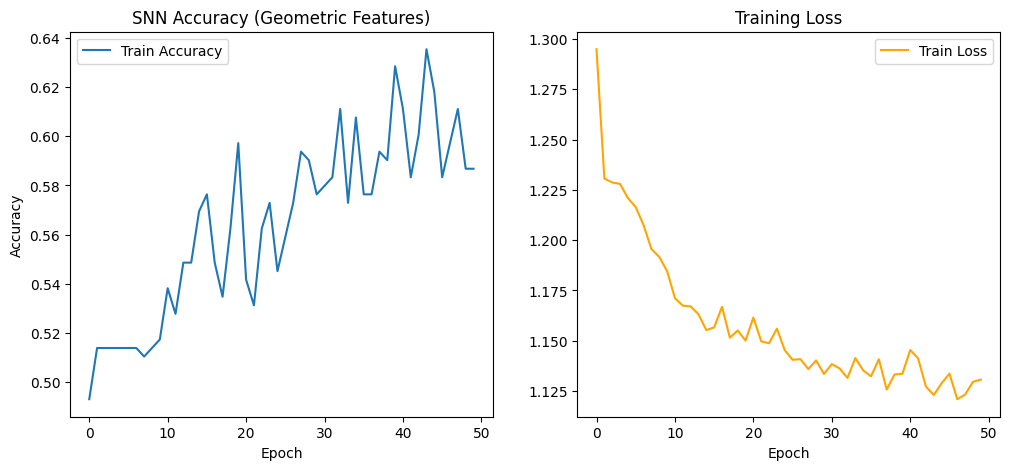

완료. 메모리 문제 없이 학습됨.


In [5]:
# @title 1. 라이브러리 설치 & 환경 설정
!pip install mne snntorch torch scipy numpy matplotlib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt

# --- GPU 설정 ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# ==========================================
# 2. Geometric Feature Extractor (Memory Safe)
# ==========================================

def compute_tangling_torch(x, dx, epsilon=1e-5):
    """
    Tangling Index Q(t) 계산 (메모리 최적화 버전)
    Batch 전체를 한 번에 행렬 연산하면 (Batch, Time, Time) 텐서가 생겨 OOM 발생.
    -> for 루프를 돌며 샘플 하나씩 계산하여 VRAM 절약.
    """
    B, C, T = x.shape
    Q_list = []

    # 배치 단위 루프: 한 번에 하나의 샘플(Trial)만 계산
    for i in range(B):
        # x[i]: (C, T)
        # Broadcasting: (C, T, 1) - (C, 1, T) -> (C, T, T) 거리 행렬 계산
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0) # 채널 합산 거리
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)

        denom = x_diff_sq + epsilon
        numer = dx_diff_sq

        ratio = numer / denom

        # 대각 성분(자기 자신과의 거리) 마스킹 (0으로 처리)
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)

        # Max over t' dimension -> (T,)
        # 각 시점 t에서 가장 꼬여있는 정도(Max Tangling)를 찾음
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)

    # (B, T) -> (B, 1, T) 채널 차원 복구 (Feature Stacking을 위해)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    """
    PyTorch를 이용한 고속 특징 추출 (Curvature + Tangling)
    Input: (Batch, Channels, Time)
    """
    # 1. Hilbert Transform (via FFT) -> Analytic Signal
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)

    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0:
        h[..., n_fft // 2] = freq[..., n_fft // 2]

    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real # 위치 (Trajectory)

    # 2. 미분 계산 (Gradient) - Central Difference
    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]

    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    # 3. Curvature (곡률)
    # k = |r' x r''| / |r'|^3 (1D 신호 근사)
    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    # 4. Tangling Index (Q) - 메모리 안전 함수 호출
    # 정규화 먼저 수행 (Scale 맞추기)
    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)

    tangling = compute_tangling_torch(r_norm, v_norm) # (B, 1, T)

    # Tangling은 채널 전체의 상태 공간 척도이므로,
    # 원래 채널 수만큼 복제해서 차원을 맞춰주거나 별도 채널로 붙임.
    # 여기서는 1채널로 압축된 Tangling 정보를 모든 채널에 Broadcasting 하는 대신
    # 별도의 1채널 Feature로 취급하여 Concatenate.
    # 하지만 Conv1d 입력 채널 수를 맞추기 위해, 여기서는 단순하게
    # 원본(64) + 곡률(64) + 탱글링(1) = 129 채널로 만듦.

    features = torch.cat([r, curvature, tangling], dim=1)

    # Final Normalization
    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    features = (features - f_mean) / (f_std + 1e-6)

    return features

# ==========================================
# 3. 데이터 로드 (MNE Physionet)
# ==========================================
def load_physionet_data(subject=1):
    # Runs: 4, 8, 12 (Left/Right Fist) | 6, 10, 14 (Both Fists/Feet)
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # Event Mapping
    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    # Epoching (0~4초)
    tmin, tmax = 0., 4.0
    epochs = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax, proj=True, picks=picks,
                        baseline=None, preload=True, verbose=False)

    # Label Mapping (4 Class 강제 매핑)
    labels = epochs.events[:, -1]
    unique_labels = np.unique(labels)
    # event id가 복잡하게 나오므로 0,1,2,3으로 단순화
    label_map = {original: idx % 4 for idx, original in enumerate(unique_labels)}
    new_labels = np.array([label_map[l] for l in labels])

    data = epochs.get_data() # (Batch, Channel, Time)
    return data, new_labels

# 실행: 데이터 로드 (Subject 1~2)
print("Loading Data...")
X_list, y_list = [], []
for sub in [1, 2]:
    x, y = load_physionet_data(sub)
    X_list.append(x)
    y_list.append(y)

X_raw = np.concatenate(X_list, axis=0)
y_raw = np.concatenate(y_list, axis=0)

# Numpy -> PyTorch Tensor (GPU로 이동)
X_tensor_raw = torch.tensor(X_raw, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_raw, dtype=torch.long).to(device)

# 특징 추출 실행 (GPU, Memory Safe)
print("Extracting Geometric Features (Safe Mode)...")
with torch.no_grad():
    X_geo = extract_geometric_features_torch(X_tensor_raw)

print(f"Feature Shape: {X_geo.shape}") # (Batch, 129, Time) 예상 (64+64+1)

# Dataset & Loader
dataset = TensorDataset(X_geo, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 배치 사이즈 16 (SNN 학습시 시간축 루프 돌므로 메모리 고려)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ==========================================
# 4. SNN Model (Tangling-Aware)
# ==========================================
class GeometricSNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.95):
        super().__init__()

        # Encoder: Tangling의 '흐름'을 읽기 위해 Kernel 5 사용
        self.encoder = nn.Conv1d(in_channels=num_inputs, out_channels=num_hidden, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(num_hidden)

        # SNN Layers
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        # x: (Batch, Channels, Time)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        spk3_rec = []

        # 1. Feature Encoding (Learnable)
        encoded = self.encoder(x) # (B, H, T)
        encoded = self.bn1(encoded)
        encoded = torch.relu(encoded)

        # 2. Temporal Loop (SNN Dynamics)
        # (Batch, Hidden, Time) -> (Time, Batch, Hidden)
        encoded = encoded.permute(2, 0, 1)

        for step in range(encoded.size(0)):
            cur_input = encoded[step]

            spk1, mem1 = self.lif1(cur_input, mem1)
            cur2 = self.fc1(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc2(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)

# ==========================================
# 5. 학습 루프
# ==========================================
num_inputs = X_geo.shape[1]
num_hidden = 128
num_outputs = 4
model = GeometricSNN(num_inputs, num_hidden, num_outputs).to(device)

criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 50
acc_hist = []
loss_hist = []

print("Start Training...")
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    iter_loss = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        spk_rec = model(data) # (Time, Batch, Class)
        loss = criterion(spk_rec, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_loss += loss.item()

        # Rate coding accuracy: 시간축 합산 후 argmax
        _, idx = spk_rec.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (idx == targets).sum().item()

    train_acc = correct / total
    avg_loss = iter_loss / len(train_loader)
    acc_hist.append(train_acc)
    loss_hist.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {train_acc*100:.2f}%")

# 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_hist, label='Train Accuracy')
plt.title("SNN Accuracy (Geometric Features)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_hist, color='orange', label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()

plt.show()
print("완료. 메모리 문제 없이 학습됨.")


Using device: cuda
Extracting Features (Log-Scale)...
Start Training (Final Breakthrough)...
Epoch 5 | Loss: 1.2364 | Acc: 50.69%
Epoch 10 | Loss: 1.2139 | Acc: 50.69%
Epoch 15 | Loss: 1.1950 | Acc: 52.78%
Epoch 20 | Loss: 1.1629 | Acc: 51.04%
Epoch 25 | Loss: 1.1535 | Acc: 52.08%
Epoch 30 | Loss: 1.1463 | Acc: 55.90%
Epoch 35 | Loss: 1.1382 | Acc: 61.81%
Epoch 40 | Loss: 1.1318 | Acc: 59.38%
Epoch 45 | Loss: 1.1280 | Acc: 61.11%
Epoch 50 | Loss: 1.1211 | Acc: 60.76%
Epoch 55 | Loss: 1.1170 | Acc: 60.42%
Epoch 60 | Loss: 1.1200 | Acc: 61.46%


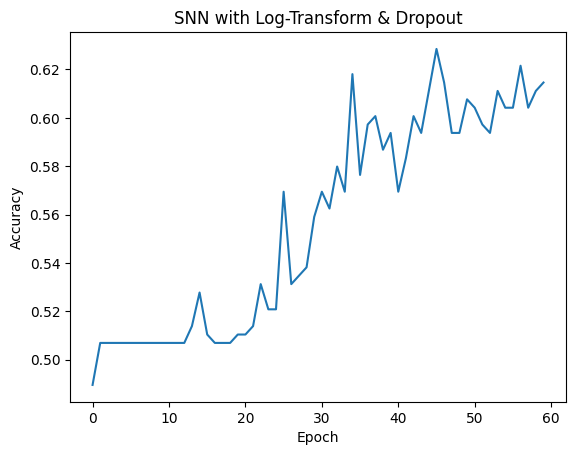

In [9]:
# @title Geometric SNN: The Breakthrough (Log + Dropout)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# ==========================================
# 1. Feature Extractor (Log-Transform Added)
# ==========================================
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        denom = x_diff_sq + epsilon
        numer = dx_diff_sq
        ratio = numer / denom
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)

        # [안전장치 1] 무한대 값 방지 (Clamp)
        ratio = torch.clamp(ratio, max=1e5)

        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_final(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0: h[..., n_fft // 2] = freq[..., n_fft // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real

    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]; r_prime[..., -1] = r[..., -1] - r[..., -2]

    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    # [수정 포인트 1] Curvature에 Log 적용 (분포 안정화)
    curvature = torch.log1p(curvature)

    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)

    # [수정 포인트 2] Tangling에 Log 적용 (핵심!)
    tangling = torch.log1p(tangling)

    features = torch.cat([r, curvature, tangling], dim=1)
    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    features = (features - f_mean) / (f_std + 1e-6)

    return features

# (데이터 로드는 이미 되어 있다고 가정하고 진행 - X_tensor_raw)
# 만약 세션 초기화됐다면 데이터 로드 코드 먼저 실행 필요
print("Extracting Features (Log-Scale)...")
with torch.no_grad():
    X_geo = extract_geometric_features_final(X_tensor_raw)

# Dataset
dataset = TensorDataset(X_geo, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ==========================================
# 2. SNN Model (Dropout Added)
# ==========================================
class GeometricSNN_Final(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.9): # Beta 0.9 (반응성 좋게)
        super().__init__()

        self.encoder = nn.Conv1d(num_inputs, num_hidden, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(num_hidden)

        # Dropout 추가 (과적합 방지)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.25)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        spk3_rec = []

        encoded = self.encoder(x)
        encoded = self.bn1(encoded)
        encoded = torch.relu(encoded)
        encoded = encoded.permute(2, 0, 1)

        for step in range(encoded.size(0)):
            cur_input = encoded[step]

            spk1, mem1 = self.lif1(cur_input, mem1)
            spk1 = self.drop1(spk1) # Dropout 적용

            cur2 = self.fc1(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.drop2(spk2) # Dropout 적용

            cur3 = self.fc2(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)

# ==========================================
# 3. Training Loop (Scheduler Added)
# ==========================================
model = GeometricSNN_Final(X_geo.shape[1], 128, 4).to(device)
criterion = SF.ce_rate_loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=1e-3) # AdamW + Weight Decay

# Scheduler: 학습률을 코사인 형태로 부드럽게 감소시킴 (수렴 유도)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

print("Start Training (Final Breakthrough)...")
acc_hist = []

for epoch in range(60): # 에포크 조금 더 줌
    model.train()
    correct = 0
    total = 0
    iter_loss = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        spk_rec = model(data)
        loss = criterion(spk_rec, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_loss += loss.item()
        _, idx = spk_rec.sum(dim=0).max(1)
        correct += (idx == targets).sum().item()
        total += targets.size(0)

    scheduler.step() # 스케줄러 실행
    train_acc = correct / total
    acc_hist.append(train_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {iter_loss/len(train_loader):.4f} | Acc: {train_acc*100:.2f}%")

plt.plot(acc_hist)
plt.title("SNN with Log-Transform & Dropout")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
